In [1]:
# File: colab_goemotions_finetune.py


import kagglehub
import os
import json
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments)
from peft import get_peft_config, LoraConfig, PeftModel
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

In [3]:
# Function to convert numeric labels to text
def convert_labels_to_one_int(example):
    #text_labels = [label_mapping[label] for label in example["labels"]]
    example["labels"] = example["labels"][0]
    return example

# Assuming `dataset` is your DatasetDict
dataset = DatasetDict({
    "train": ds["train"].map(convert_labels_to_one_int),
    "validation": ds["validation"].map(convert_labels_to_one_int),
    "test": ds["test"].map(convert_labels_to_one_int),
})



"""# Assuming you have already loaded the DatasetDict as `dataset`
dataset = DatasetDict({
    "train": dataset["test"],         # Swap test with train
    "validation": dataset["validation"],  # Keep validation as is
    "test": dataset["train"]          # Swap train with test
})"""

'# Assuming you have already loaded the DatasetDict as `dataset`\ndataset = DatasetDict({\n    "train": dataset["test"],         # Swap test with train\n    "validation": dataset["validation"],  # Keep validation as is\n    "test": dataset["train"]          # Swap train with test\n})'

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [5]:
def preprocess_labels(example):
    example['labels'] = max(0, min(example['labels'], 27))  # Ensure labels are within range
    return example

dataset = dataset.map(preprocess_labels)

In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
"""
# Prepare the dataset for training
def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)

# Prepare the tokenizers with padding token
tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Ensure each tokenizer has a padding token
for model_name, tokenizer in tokenizers.items():
    if tokenizer.pad_token is None:
        if tokenizer.eos_token:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Models for fine-tuning
models = {
    "gpt2": {
        "path": "gpt2",
        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),
        "size": "500MB"
    },
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=27, cache_dir="./models"),
        "size": "750MB"
    },
    "roberta": {
        "path": "roberta-base",
        "model": AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=27, cache_dir="./models"),
        "size": "1GB"
    }
}
"""

'\n# Prepare the dataset for training\ndef preprocess_function(example, tokenizer, max_length=128):\n    return tokenizer(example[\'text\'], truncation=True, padding=\'max_length\', max_length=max_length)\n\n# Prepare the tokenizers with padding token\ntokenizers = {\n    "gpt2": AutoTokenizer.from_pretrained("gpt2"),\n    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),\n    "roberta": AutoTokenizer.from_pretrained("roberta-base"),\n}\n\n# Ensure each tokenizer has a padding token\nfor model_name, tokenizer in tokenizers.items():\n    if tokenizer.pad_token is None:\n        if tokenizer.eos_token:\n            tokenizer.pad_token = tokenizer.eos_token\n        else:\n            tokenizer.add_special_tokens({\'pad_token\': \'[PAD]\'})\n\n\n# Models for fine-tuning\nmodels = {\n    "gpt2": {\n        "path": "gpt2",\n        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),\n        "size": "500MB"\n    },\n    "distilbert": {\n       

In [8]:
def train_model(model_name, model, tokenizer, dataset, training_args, lora=False):
    if lora:
        print(f"Applying QLoRA to {model_name}...")
        # Dynamically set target modules based on the model type
        if model_name == "distilbert":
            target_modules = ["ffn.lin1", "ffn.lin2"]
        elif model_name == "roberta":
            target_modules = ["intermediate.dense", "output.dense"]
        elif model_name == "gpt2":
            target_modules = ["c_fc", "c_proj"]
        else:
            raise ValueError(f"LoRA target modules not defined for {model_name}")

        config = LoraConfig(
            r=16, lora_alpha=32, lora_dropout=0.1, target_modules=target_modules
        )
        model = PeftModel(model, config)

        # Freeze base model parameters
        for param in model.base_model.parameters():
            param.requires_grad = False
        print("Base model parameters frozen.")

        # Ensure LoRA parameters are trainable
        for name, param in model.named_parameters():
            if 'lora' in name:  # LoRA layers will have 'lora' in their names
                param.requires_grad = True
        print("LoRA parameters are trainable.")

    dataset = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    dataset = dataset.remove_columns(['id'])  # Adjust as per GoEmotions structure
    from transformers import TrainerCallback
    import json
    from sklearn.metrics import accuracy_score
    import numpy as np

    # Define the compute_metrics function
    def compute_metrics(pred):
        logits, labels = pred
        predictions = np.argmax(logits, axis=-1)

        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate the loss (use the loss function used during training)
        # Here we're using CrossEntropyLoss as an example
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(torch.tensor(logits), torch.tensor(labels)).item()  # Calculate loss

        return {"accuracy": accuracy, "loss": loss}


    class LogMetricsCallback(TrainerCallback):
        def __init__(self, log_dir="./logs/log_history_real_train_data.json"):
            self.log_dir = log_dir
            self.logs = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs:
                log_entry = {
                    "epoch": logs.get("epoch"),
                    "train_loss": logs.get("loss"),
                    "learning_rate": logs.get("learning_rate"),
                    "grad_norm": logs.get("grad_norm", None),  # Gradient norm (if available)
                    "eval_loss": logs.get("eval_loss", None),  # Eval loss
                    "eval_accuracy": logs.get("eval_accuracy", None),  # Eval accuracy
                    "optimizer_state": logs.get("optimizer_state", None)  # Optimizer state (if available)
                }
                self.logs.append(log_entry)
                
                # Save logs to a file after each logging step
                with open(self.log_dir, "w") as f:
                    json.dump(self.logs, f, indent=4)


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[LogMetricsCallback(log_dir="./logs/log_history.json")]  # Custom callback
    )
    trainer.train()
    return trainer


# Metrics computation
accuracy_metric = evaluate.load("accuracy")

"""def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc}"""



'def compute_metrics(pred):\n    logits, labels = pred\n    predictions = np.argmax(logits, axis=-1)\n    acc = accuracy_metric.compute(predictions=predictions, references=labels)\n    return {"accuracy": acc}'

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [12]:
import os

# Enable CUDA launch blocking for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"




# Training configurations
training_args = TrainingArguments(
    output_dir="./results_real_data",
    evaluation_strategy="steps",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=False,
    logging_first_step=False,   # Make sure logs are being stored
)

# Train each model
results = {}
for model_name, model_info in models.items():
    print(f"Training {model_name} ({model_info['size']}) with standard fine-tuning...")
    results[model_name] = {}
    trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=False)
    results[model_name]['standard'] = trainer.evaluate()
    
    """print(f"Training {model_name} ({model_info['size']}) with QLoRA...")
    trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=True)
    results[model_name]['qlora'] = trainer.evaluate()"""

c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training distilbert (750MB) with standard fine-tuning...


  0%|          | 0/27140 [00:00<?, ?it/s]

{'loss': 2.2985, 'grad_norm': 8.442850112915039, 'learning_rate': 1.9631540162122333e-05, 'epoch': 0.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8687649965286255, 'eval_accuracy': 0.48157021747143386, 'eval_runtime': 5.5522, 'eval_samples_per_second': 977.263, 'eval_steps_per_second': 61.237, 'epoch': 0.18}
{'loss': 1.7215, 'grad_norm': 9.496930122375488, 'learning_rate': 1.926308032424466e-05, 'epoch': 0.37}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6021133661270142, 'eval_accuracy': 0.5425727976409879, 'eval_runtime': 5.6248, 'eval_samples_per_second': 964.658, 'eval_steps_per_second': 60.447, 'epoch': 0.37}
{'loss': 1.6032, 'grad_norm': 7.353003978729248, 'learning_rate': 1.8894620486366988e-05, 'epoch': 0.55}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5013716220855713, 'eval_accuracy': 0.5641356431994102, 'eval_runtime': 5.4988, 'eval_samples_per_second': 986.762, 'eval_steps_per_second': 61.832, 'epoch': 0.55}
{'loss': 1.5309, 'grad_norm': 8.886563301086426, 'learning_rate': 1.8526160648489315e-05, 'epoch': 0.74}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4551864862442017, 'eval_accuracy': 0.5715075562108367, 'eval_runtime': 5.5063, 'eval_samples_per_second': 985.408, 'eval_steps_per_second': 61.747, 'epoch': 0.74}
{'loss': 1.508, 'grad_norm': 7.806018829345703, 'learning_rate': 1.8157700810611646e-05, 'epoch': 0.92}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4476125240325928, 'eval_accuracy': 0.5669001105786952, 'eval_runtime': 5.797, 'eval_samples_per_second': 935.995, 'eval_steps_per_second': 58.651, 'epoch': 0.92}
{'loss': 1.3885, 'grad_norm': 7.4979705810546875, 'learning_rate': 1.7789240972733973e-05, 'epoch': 1.11}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3986400365829468, 'eval_accuracy': 0.5812753409509768, 'eval_runtime': 5.6383, 'eval_samples_per_second': 962.354, 'eval_steps_per_second': 60.302, 'epoch': 1.11}
{'loss': 1.2941, 'grad_norm': 10.954540252685547, 'learning_rate': 1.74207811348563e-05, 'epoch': 1.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.417325735092163, 'eval_accuracy': 0.5739034279395503, 'eval_runtime': 8.3107, 'eval_samples_per_second': 652.892, 'eval_steps_per_second': 40.911, 'epoch': 1.29}
{'loss': 1.3165, 'grad_norm': 8.720344543457031, 'learning_rate': 1.7052321296978632e-05, 'epoch': 1.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3974523544311523, 'eval_accuracy': 0.5823811279026907, 'eval_runtime': 8.2235, 'eval_samples_per_second': 659.815, 'eval_steps_per_second': 41.345, 'epoch': 1.47}
{'loss': 1.3025, 'grad_norm': 12.354914665222168, 'learning_rate': 1.668386145910096e-05, 'epoch': 1.66}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.400770902633667, 'eval_accuracy': 0.573534832288979, 'eval_runtime': 8.2389, 'eval_samples_per_second': 658.585, 'eval_steps_per_second': 41.268, 'epoch': 1.66}
{'loss': 1.2586, 'grad_norm': 8.789066314697266, 'learning_rate': 1.6315401621223287e-05, 'epoch': 1.84}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.38312566280365, 'eval_accuracy': 0.5829340213785478, 'eval_runtime': 8.2071, 'eval_samples_per_second': 661.136, 'eval_steps_per_second': 41.428, 'epoch': 1.84}
{'loss': 1.2701, 'grad_norm': 13.429469108581543, 'learning_rate': 1.5946941783345618e-05, 'epoch': 2.03}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.3892955780029297, 'eval_accuracy': 0.5829340213785478, 'eval_runtime': 8.2087, 'eval_samples_per_second': 661.007, 'eval_steps_per_second': 41.42, 'epoch': 2.03}
{'loss': 1.0867, 'grad_norm': 13.859712600708008, 'learning_rate': 1.5578481945467945e-05, 'epoch': 2.21}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.413759469985962, 'eval_accuracy': 0.5868042757095466, 'eval_runtime': 8.1615, 'eval_samples_per_second': 664.828, 'eval_steps_per_second': 41.659, 'epoch': 2.21}
{'loss': 1.0737, 'grad_norm': 10.028066635131836, 'learning_rate': 1.5210022107590274e-05, 'epoch': 2.39}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.437225580215454, 'eval_accuracy': 0.5803538518245485, 'eval_runtime': 8.1938, 'eval_samples_per_second': 662.209, 'eval_steps_per_second': 41.495, 'epoch': 2.39}
{'loss': 1.1076, 'grad_norm': 13.003308296203613, 'learning_rate': 1.4841562269712602e-05, 'epoch': 2.58}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4420669078826904, 'eval_accuracy': 0.570217471433837, 'eval_runtime': 8.1437, 'eval_samples_per_second': 666.28, 'eval_steps_per_second': 41.75, 'epoch': 2.58}
{'loss': 1.1003, 'grad_norm': 10.83072566986084, 'learning_rate': 1.4473102431834931e-05, 'epoch': 2.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4346519708633423, 'eval_accuracy': 0.5720604496866937, 'eval_runtime': 8.1757, 'eval_samples_per_second': 663.677, 'eval_steps_per_second': 41.587, 'epoch': 2.76}
{'loss': 1.0508, 'grad_norm': 13.523743629455566, 'learning_rate': 1.410464259395726e-05, 'epoch': 2.95}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4202500581741333, 'eval_accuracy': 0.5810910431256912, 'eval_runtime': 8.1939, 'eval_samples_per_second': 662.198, 'eval_steps_per_second': 41.494, 'epoch': 2.95}
{'loss': 0.9395, 'grad_norm': 10.550268173217773, 'learning_rate': 1.3736182756079588e-05, 'epoch': 3.13}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.468843698501587, 'eval_accuracy': 0.5772207887946922, 'eval_runtime': 8.177, 'eval_samples_per_second': 663.57, 'eval_steps_per_second': 41.58, 'epoch': 3.13}
{'loss': 0.8669, 'grad_norm': 12.690872192382812, 'learning_rate': 1.3367722918201917e-05, 'epoch': 3.32}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5059891939163208, 'eval_accuracy': 0.5617397714706966, 'eval_runtime': 8.1622, 'eval_samples_per_second': 664.768, 'eval_steps_per_second': 41.655, 'epoch': 3.32}
{'loss': 0.8706, 'grad_norm': 14.737988471984863, 'learning_rate': 1.2999263080324244e-05, 'epoch': 3.5}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.4897124767303467, 'eval_accuracy': 0.5696645779579801, 'eval_runtime': 8.1931, 'eval_samples_per_second': 662.265, 'eval_steps_per_second': 41.498, 'epoch': 3.5}
{'loss': 0.882, 'grad_norm': 12.66919994354248, 'learning_rate': 1.2630803242446574e-05, 'epoch': 3.68}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5010017156600952, 'eval_accuracy': 0.5755621083671213, 'eval_runtime': 8.1749, 'eval_samples_per_second': 663.739, 'eval_steps_per_second': 41.591, 'epoch': 3.68}
{'loss': 0.889, 'grad_norm': 20.95216941833496, 'learning_rate': 1.2262343404568904e-05, 'epoch': 3.87}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5280932188034058, 'eval_accuracy': 0.564319941024696, 'eval_runtime': 8.1449, 'eval_samples_per_second': 666.181, 'eval_steps_per_second': 41.744, 'epoch': 3.87}
{'loss': 0.811, 'grad_norm': 15.314448356628418, 'learning_rate': 1.1893883566691232e-05, 'epoch': 4.05}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.5768486261367798, 'eval_accuracy': 0.5641356431994102, 'eval_runtime': 8.1609, 'eval_samples_per_second': 664.876, 'eval_steps_per_second': 41.662, 'epoch': 4.05}
{'loss': 0.6742, 'grad_norm': 19.20982551574707, 'learning_rate': 1.1525423728813561e-05, 'epoch': 4.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6231111288070679, 'eval_accuracy': 0.5608182823442683, 'eval_runtime': 8.1941, 'eval_samples_per_second': 662.183, 'eval_steps_per_second': 41.493, 'epoch': 4.24}
{'loss': 0.6761, 'grad_norm': 9.535650253295898, 'learning_rate': 1.1156963890935889e-05, 'epoch': 4.42}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6571768522262573, 'eval_accuracy': 0.5538149649834132, 'eval_runtime': 8.1786, 'eval_samples_per_second': 663.436, 'eval_steps_per_second': 41.572, 'epoch': 4.42}
{'loss': 0.691, 'grad_norm': 15.71125316619873, 'learning_rate': 1.0788504053058218e-05, 'epoch': 4.61}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6883662939071655, 'eval_accuracy': 0.5469959454478437, 'eval_runtime': 8.2114, 'eval_samples_per_second': 660.789, 'eval_steps_per_second': 41.406, 'epoch': 4.61}
{'loss': 0.6918, 'grad_norm': 21.9290771484375, 'learning_rate': 1.0420044215180547e-05, 'epoch': 4.79}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6838455200195312, 'eval_accuracy': 0.5578695171396978, 'eval_runtime': 8.2402, 'eval_samples_per_second': 658.482, 'eval_steps_per_second': 41.261, 'epoch': 4.79}
{'loss': 0.6885, 'grad_norm': 18.26828384399414, 'learning_rate': 1.0051584377302874e-05, 'epoch': 4.97}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6889889240264893, 'eval_accuracy': 0.5580538149649834, 'eval_runtime': 8.1809, 'eval_samples_per_second': 663.252, 'eval_steps_per_second': 41.56, 'epoch': 4.97}
{'loss': 0.5442, 'grad_norm': 8.847016334533691, 'learning_rate': 9.683124539425204e-06, 'epoch': 5.16}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.7606754302978516, 'eval_accuracy': 0.5436785845927018, 'eval_runtime': 8.1774, 'eval_samples_per_second': 663.533, 'eval_steps_per_second': 41.578, 'epoch': 5.16}
{'loss': 0.5246, 'grad_norm': 15.128473281860352, 'learning_rate': 9.314664701547533e-06, 'epoch': 5.34}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8032312393188477, 'eval_accuracy': 0.5429413932915591, 'eval_runtime': 8.2095, 'eval_samples_per_second': 660.94, 'eval_steps_per_second': 41.415, 'epoch': 5.34}
{'loss': 0.5278, 'grad_norm': 19.401351928710938, 'learning_rate': 8.94620486366986e-06, 'epoch': 5.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8355642557144165, 'eval_accuracy': 0.5492075193512717, 'eval_runtime': 8.2094, 'eval_samples_per_second': 660.949, 'eval_steps_per_second': 41.416, 'epoch': 5.53}
{'loss': 0.5262, 'grad_norm': 20.14927864074707, 'learning_rate': 8.57774502579219e-06, 'epoch': 5.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8532239198684692, 'eval_accuracy': 0.5486546258754147, 'eval_runtime': 8.1942, 'eval_samples_per_second': 662.179, 'eval_steps_per_second': 41.493, 'epoch': 5.71}
{'loss': 0.5211, 'grad_norm': 21.110206604003906, 'learning_rate': 8.209285187914517e-06, 'epoch': 5.9}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8531032800674438, 'eval_accuracy': 0.5497604128271286, 'eval_runtime': 8.2262, 'eval_samples_per_second': 659.596, 'eval_steps_per_second': 41.331, 'epoch': 5.9}
{'loss': 0.47, 'grad_norm': 8.549769401550293, 'learning_rate': 7.840825350036846e-06, 'epoch': 6.08}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.9090166091918945, 'eval_accuracy': 0.5499447106524143, 'eval_runtime': 8.1764, 'eval_samples_per_second': 663.62, 'eval_steps_per_second': 41.583, 'epoch': 6.08}
{'loss': 0.3852, 'grad_norm': 19.753097534179688, 'learning_rate': 7.472365512159175e-06, 'epoch': 6.26}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.9741771221160889, 'eval_accuracy': 0.549023221525986, 'eval_runtime': 8.2075, 'eval_samples_per_second': 661.1, 'eval_steps_per_second': 41.425, 'epoch': 6.26}
{'loss': 0.4022, 'grad_norm': 14.705588340759277, 'learning_rate': 7.103905674281504e-06, 'epoch': 6.45}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.013284683227539, 'eval_accuracy': 0.5416513085145596, 'eval_runtime': 8.2254, 'eval_samples_per_second': 659.666, 'eval_steps_per_second': 41.335, 'epoch': 6.45}
{'loss': 0.3912, 'grad_norm': 14.297801971435547, 'learning_rate': 6.735445836403832e-06, 'epoch': 6.63}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.021228313446045, 'eval_accuracy': 0.5455215628455584, 'eval_runtime': 8.1618, 'eval_samples_per_second': 664.808, 'eval_steps_per_second': 41.658, 'epoch': 6.63}
{'loss': 0.4004, 'grad_norm': 16.099102020263672, 'learning_rate': 6.36698599852616e-06, 'epoch': 6.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0546786785125732, 'eval_accuracy': 0.5409141172134169, 'eval_runtime': 8.1611, 'eval_samples_per_second': 664.86, 'eval_steps_per_second': 41.661, 'epoch': 6.82}
{'loss': 0.4252, 'grad_norm': 24.570035934448242, 'learning_rate': 5.99852616064849e-06, 'epoch': 7.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0527143478393555, 'eval_accuracy': 0.5453372650202728, 'eval_runtime': 8.2231, 'eval_samples_per_second': 659.845, 'eval_steps_per_second': 41.347, 'epoch': 7.0}
{'loss': 0.3173, 'grad_norm': 18.48667335510254, 'learning_rate': 5.630066322770819e-06, 'epoch': 7.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.111485719680786, 'eval_accuracy': 0.5401769259122743, 'eval_runtime': 8.1803, 'eval_samples_per_second': 663.301, 'eval_steps_per_second': 41.563, 'epoch': 7.18}
{'loss': 0.3188, 'grad_norm': 12.301214218139648, 'learning_rate': 5.261606484893147e-06, 'epoch': 7.37}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.131098747253418, 'eval_accuracy': 0.5455215628455584, 'eval_runtime': 8.1463, 'eval_samples_per_second': 666.072, 'eval_steps_per_second': 41.737, 'epoch': 7.37}
{'loss': 0.3156, 'grad_norm': 26.333208084106445, 'learning_rate': 4.893146647015476e-06, 'epoch': 7.55}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.1599488258361816, 'eval_accuracy': 0.5361223737559897, 'eval_runtime': 8.1791, 'eval_samples_per_second': 663.398, 'eval_steps_per_second': 41.569, 'epoch': 7.55}
{'loss': 0.3252, 'grad_norm': 13.57181167602539, 'learning_rate': 4.524686809137805e-06, 'epoch': 7.74}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.1951727867126465, 'eval_accuracy': 0.5357537781054184, 'eval_runtime': 8.1, 'eval_samples_per_second': 669.876, 'eval_steps_per_second': 41.975, 'epoch': 7.74}
{'loss': 0.3136, 'grad_norm': 15.002897262573242, 'learning_rate': 4.156226971260133e-06, 'epoch': 7.92}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2044460773468018, 'eval_accuracy': 0.5403612237375599, 'eval_runtime': 8.1612, 'eval_samples_per_second': 664.85, 'eval_steps_per_second': 41.66, 'epoch': 7.92}
{'loss': 0.2898, 'grad_norm': 13.997879981994629, 'learning_rate': 3.7877671333824617e-06, 'epoch': 8.11}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2415904998779297, 'eval_accuracy': 0.5368595650571323, 'eval_runtime': 8.1612, 'eval_samples_per_second': 664.856, 'eval_steps_per_second': 41.661, 'epoch': 8.11}
{'loss': 0.2369, 'grad_norm': 17.925912857055664, 'learning_rate': 3.41930729550479e-06, 'epoch': 8.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2773585319519043, 'eval_accuracy': 0.5377810541835606, 'eval_runtime': 8.1762, 'eval_samples_per_second': 663.63, 'eval_steps_per_second': 41.584, 'epoch': 8.29}
{'loss': 0.2446, 'grad_norm': 17.715852737426758, 'learning_rate': 3.0508474576271192e-06, 'epoch': 8.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.304311752319336, 'eval_accuracy': 0.5379653520088463, 'eval_runtime': 8.1783, 'eval_samples_per_second': 663.463, 'eval_steps_per_second': 41.573, 'epoch': 8.47}
{'loss': 0.2624, 'grad_norm': 27.54595375061035, 'learning_rate': 2.6823876197494476e-06, 'epoch': 8.66}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.312304973602295, 'eval_accuracy': 0.5418356063398452, 'eval_runtime': 8.1595, 'eval_samples_per_second': 664.991, 'eval_steps_per_second': 41.669, 'epoch': 8.66}
{'loss': 0.2599, 'grad_norm': 17.46660804748535, 'learning_rate': 2.3139277818717763e-06, 'epoch': 8.84}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3318185806274414, 'eval_accuracy': 0.5381496498341319, 'eval_runtime': 8.1631, 'eval_samples_per_second': 664.695, 'eval_steps_per_second': 41.651, 'epoch': 8.84}
{'loss': 0.2479, 'grad_norm': 10.198465347290039, 'learning_rate': 1.9454679439941047e-06, 'epoch': 9.03}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.336245536804199, 'eval_accuracy': 0.5352008846295614, 'eval_runtime': 8.2427, 'eval_samples_per_second': 658.282, 'eval_steps_per_second': 41.249, 'epoch': 9.03}
{'loss': 0.2064, 'grad_norm': 7.533511638641357, 'learning_rate': 1.5770081061164336e-06, 'epoch': 9.21}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3503453731536865, 'eval_accuracy': 0.5383339476594177, 'eval_runtime': 8.1612, 'eval_samples_per_second': 664.854, 'eval_steps_per_second': 41.661, 'epoch': 9.21}
{'loss': 0.2163, 'grad_norm': 9.727627754211426, 'learning_rate': 1.2085482682387622e-06, 'epoch': 9.4}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.368198871612549, 'eval_accuracy': 0.5357537781054184, 'eval_runtime': 8.2106, 'eval_samples_per_second': 660.85, 'eval_steps_per_second': 41.41, 'epoch': 9.4}
{'loss': 0.2246, 'grad_norm': 29.01853370666504, 'learning_rate': 8.400884303610906e-07, 'epoch': 9.58}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.3671951293945312, 'eval_accuracy': 0.5379653520088463, 'eval_runtime': 8.1469, 'eval_samples_per_second': 666.024, 'eval_steps_per_second': 41.734, 'epoch': 9.58}
{'loss': 0.2192, 'grad_norm': 35.776485443115234, 'learning_rate': 4.7162859248341935e-07, 'epoch': 9.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.369152784347534, 'eval_accuracy': 0.535385182454847, 'eval_runtime': 8.1784, 'eval_samples_per_second': 663.455, 'eval_steps_per_second': 41.573, 'epoch': 9.76}
{'loss': 0.2017, 'grad_norm': 10.333885192871094, 'learning_rate': 1.0316875460574797e-07, 'epoch': 9.95}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.377173900604248, 'eval_accuracy': 0.535938075930704, 'eval_runtime': 8.1414, 'eval_samples_per_second': 666.468, 'eval_steps_per_second': 41.762, 'epoch': 9.95}
{'train_runtime': 2373.2054, 'train_samples_per_second': 182.917, 'train_steps_per_second': 11.436, 'train_loss': 0.7364988314376303, 'epoch': 10.0}


  0%|          | 0/340 [00:00<?, ?it/s]

In [13]:
trainer

In [14]:
results

{'distilbert': {'standard': {'eval_loss': 2.3779425621032715,
   'eval_accuracy': 0.5363066715812753,
   'eval_runtime': 8.5313,
   'eval_samples_per_second': 636.009,
   'eval_steps_per_second': 39.853,
   'epoch': 10.0}}}

In [15]:
# Print the results directly
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for method, evaluation in metrics.items():
        print(f"  Method: {method}")
        for metric, value in evaluation.items():
            print(f"    {metric}: {value}")


Results for distilbert:
  Method: standard
    eval_loss: 2.3779425621032715
    eval_accuracy: 0.5363066715812753
    eval_runtime: 8.5313
    eval_samples_per_second: 636.009
    eval_steps_per_second: 39.853
    epoch: 10.0


In [16]:
import pandas as pd

# Prepare data for a DataFrame
data = []
for model_name, metrics in results.items():
    for method, evaluation in metrics.items():
        row = {"Model": model_name, "Method": method}
        row.update(evaluation)  # Add metrics to the row
        data.append(row)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


        Model    Method  eval_loss  eval_accuracy  eval_runtime  \
0  distilbert  standard   2.377943       0.536307        8.5313   

   eval_samples_per_second  eval_steps_per_second  epoch  
0                  636.009                 39.853   10.0  


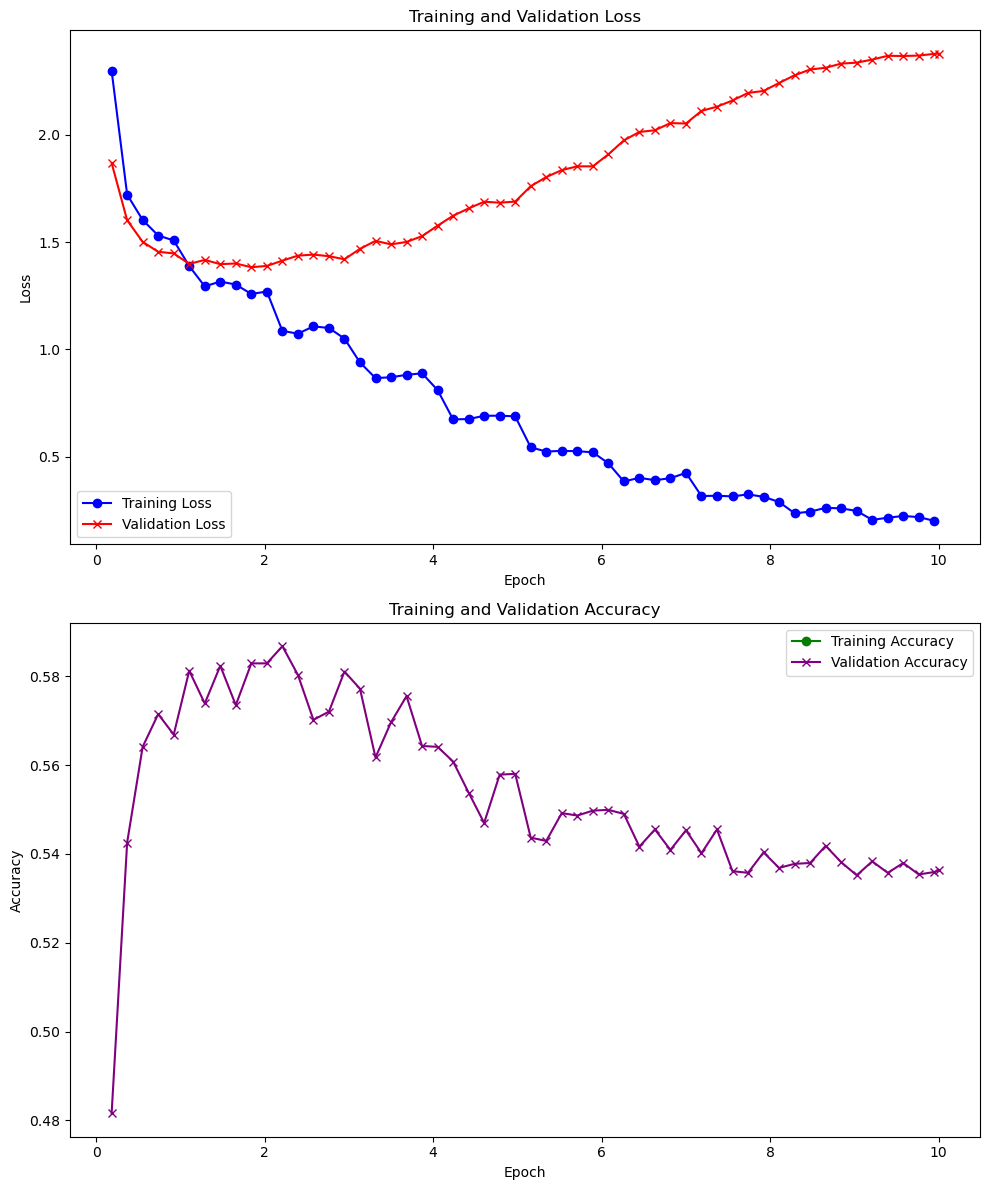

In [17]:
import json
import matplotlib.pyplot as plt

# Load logs from the file
with open("./logs/log_history.json", "r") as f:
    logs = json.load(f)

# Lists to store metrics
epochs = []
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

# Extracting relevant metrics from the logs
for log in logs:
    epoch = log.get("epoch")
    if epoch is not None:
        epochs.append(epoch)
        
        # Check if training loss is available
        if log.get("train_loss") is not None:
            train_loss.append((epoch, log["train_loss"]))
        
        # Check if validation loss is available
        if log.get("eval_loss") is not None:
            eval_loss.append((epoch, log["eval_loss"]))
        
        # Check if training accuracy is available
        if log.get("train_accuracy") is not None:
            train_accuracy.append((epoch, log["train_accuracy"]))
        
        # Check if validation accuracy is available
        if log.get("eval_accuracy") is not None:
            eval_accuracy.append((epoch, log["eval_accuracy"]))

# Sort the lists based on epochs (if they aren't already sorted)
train_loss.sort(key=lambda x: x[0])
eval_loss.sort(key=lambda x: x[0])
train_accuracy.sort(key=lambda x: x[0])
eval_accuracy.sort(key=lambda x: x[0])

# Unpack the sorted values
train_loss_epochs, train_loss_values = zip(*train_loss) if train_loss else ([], [])
eval_loss_epochs, eval_loss_values = zip(*eval_loss) if eval_loss else ([], [])
train_accuracy_epochs, train_accuracy_values = zip(*train_accuracy) if train_accuracy else ([], [])
eval_accuracy_epochs, eval_accuracy_values = zip(*eval_accuracy) if eval_accuracy else ([], [])

# Plotting Training and Evaluation Loss and Accuracy
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Training vs Validation Loss
axes[0].plot(train_loss_epochs, train_loss_values, label="Training Loss", color="blue", marker="o")
axes[0].plot(eval_loss_epochs, eval_loss_values, label="Validation Loss", color="red", marker="x")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Training vs Validation Accuracy
axes[1].plot(train_accuracy_epochs, train_accuracy_values, label="Training Accuracy", color="green", marker="o")
axes[1].plot(eval_accuracy_epochs, eval_accuracy_values, label="Validation Accuracy", color="purple", marker="x")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


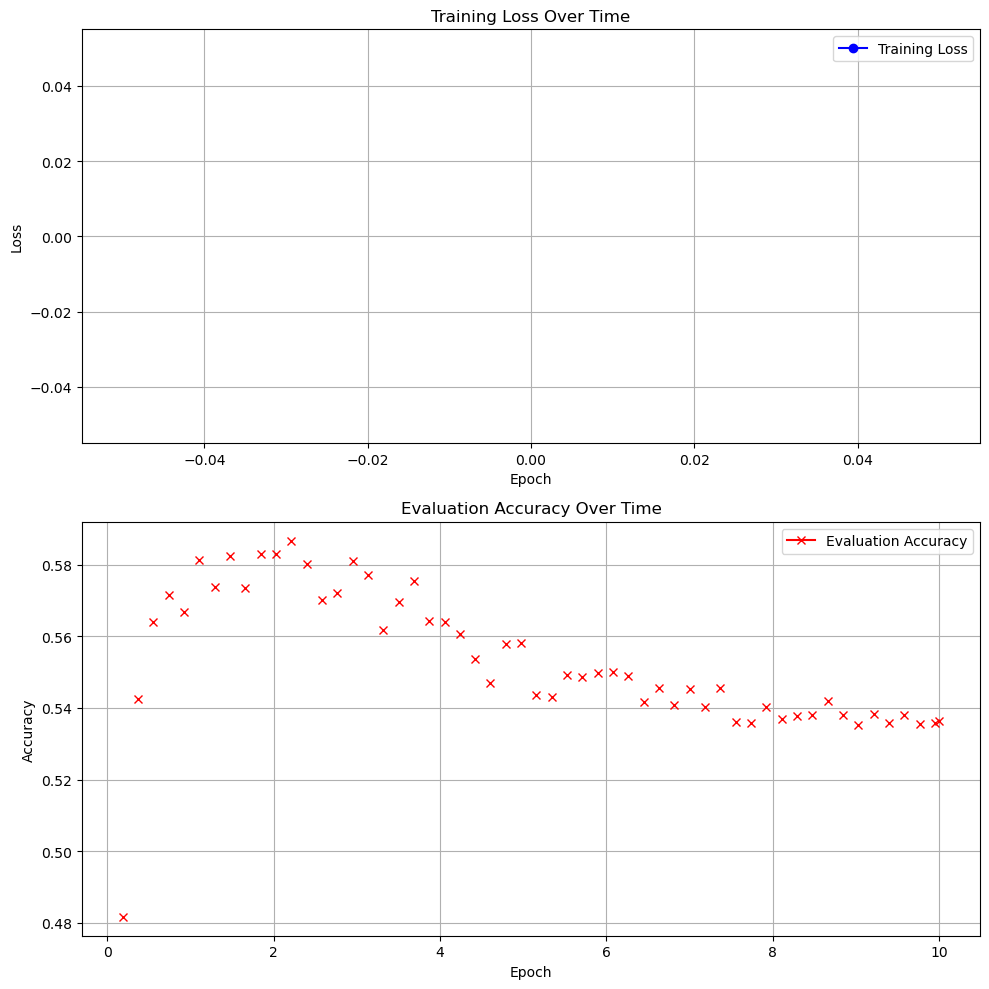

In [18]:
import json
import matplotlib.pyplot as plt

# Load logs from file
logs = []
with open("./logs/log_history.json", "r") as f:  # Adjust path as needed
    logs = json.load(f)

# Initialize lists to store data for plotting
train_epochs = []
train_loss = []
eval_epochs = []
eval_accuracy = []

# Extract data for plotting
for log in logs:
    # Extract training loss and epochs
    if "loss" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    
    # Extract evaluation accuracy and epochs
    if "eval_accuracy" in log:
        eval_epochs.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss over Time
ax1.plot(train_epochs, train_loss, label="Training Loss", color='blue', marker='o')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Time")
ax1.legend()
ax1.grid(True)

# Plot Evaluation Accuracy over Time
ax2.plot(eval_epochs, eval_accuracy, label="Evaluation Accuracy", color='red', marker='x')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Evaluation Accuracy Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


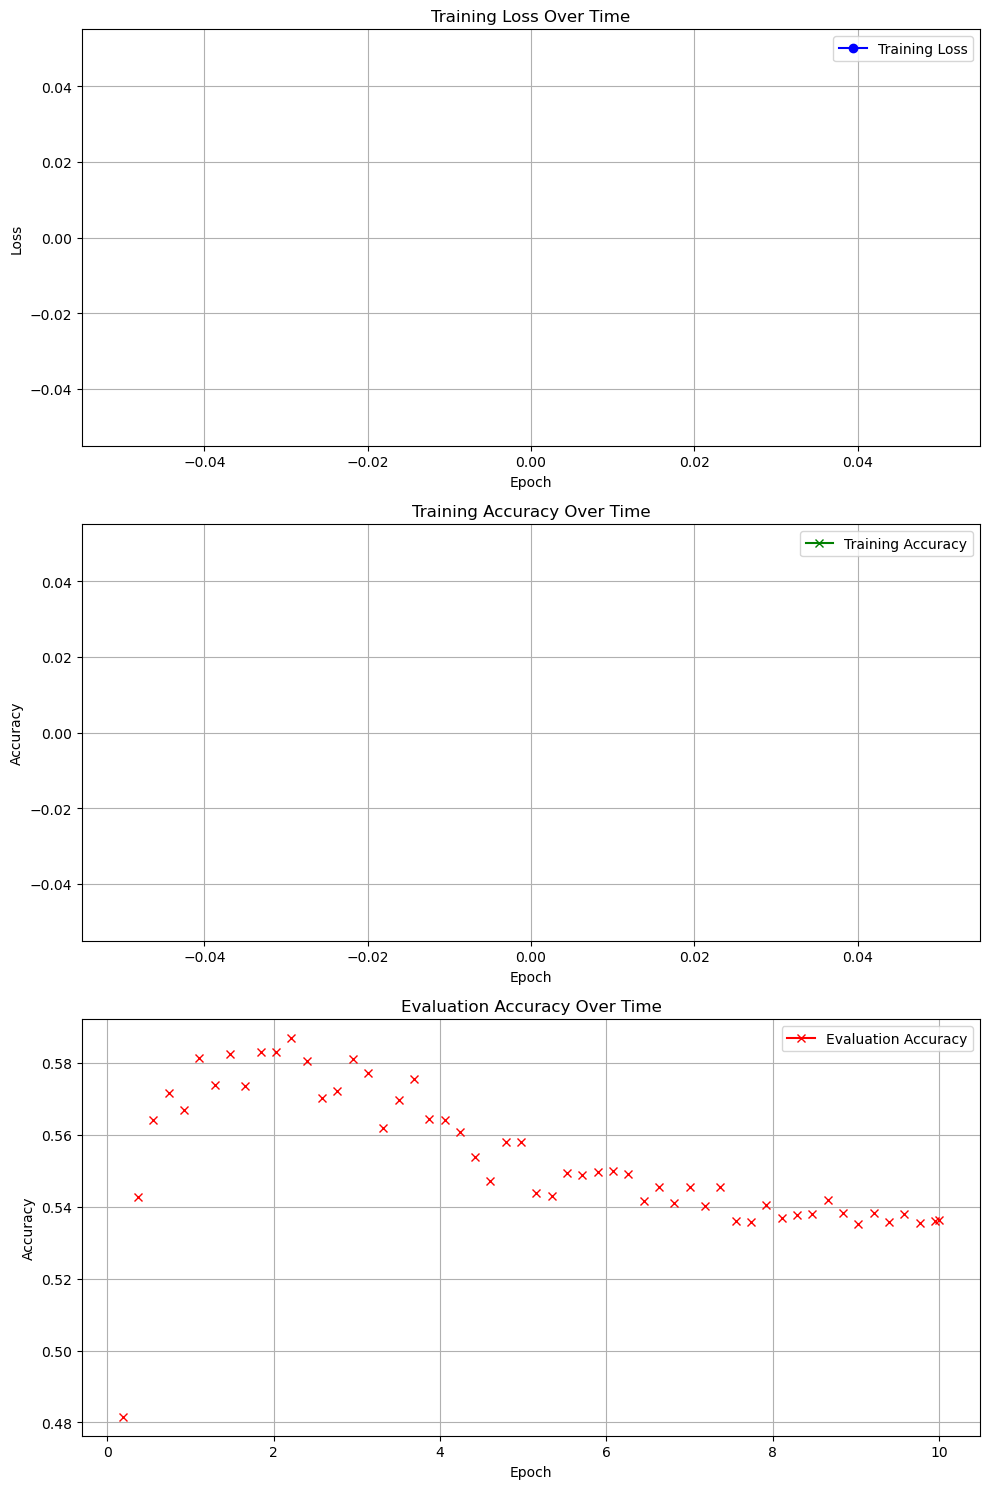

In [19]:
import json
import matplotlib.pyplot as plt

# Load logs from file
logs = []
with open("./logs/log_history.json", "r") as f:  # Adjust path as needed
    logs = json.load(f)

# Initialize lists to store data for plotting
train_epochs = []
train_loss = []
train_accuracy = []
eval_epochs = []
eval_accuracy = []

# Extract data for plotting
for log in logs:
    # Extract training loss, accuracy, and epochs
    if "loss" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "accuracy" in log:
        train_accuracy.append(log["accuracy"])
    
    # Extract evaluation accuracy and epochs
    if "eval_accuracy" in log:
        eval_epochs.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot Training Loss over Time
axes[0].plot(train_epochs, train_loss, label="Training Loss", color='blue', marker='o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss Over Time")
axes[0].legend()
axes[0].grid(True)

# Plot Training Accuracy over Time
axes[1].plot(train_epochs, train_accuracy, label="Training Accuracy", color='green', marker='x')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training Accuracy Over Time")
axes[1].legend()
axes[1].grid(True)

# Plot Evaluation Accuracy over Time
axes[2].plot(eval_epochs, eval_accuracy, label="Evaluation Accuracy", color='red', marker='x')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Evaluation Accuracy Over Time")
axes[2].legend()
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [20]:




# Plot results
print("Plotting results...")
def plot_results(results):
    plt.figure(figsize=(10, 6))
    for model_name, res in results.items():
        accuracies = [res['standard']['accuracy'], res['qlora']['accuracy']]
        plt.plot(['Standard', 'QLoRA'], accuracies, label=model_name)
    
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Fine-tuning Method')
    plt.legend()
    plt.grid()
    plt.show()

plot_results(results)

# Confusion matrix (example for GPT-2 standard fine-tuning)
print("Computing confusion matrix for GPT-2 (standard fine-tuning)...")
y_true = dataset['validation']['labels']
y_pred = trainer.predict(dataset['validation']).predictions
y_pred = np.argmax(y_pred, axis=-1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for GPT-2 Standard Fine-tuning")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


Plotting results...


KeyError: 'accuracy'

<Figure size 1000x600 with 0 Axes>